In [1]:

import os
import json
import re
from collections import defaultdict
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
for dirname, _, filenames in os.walk('D:/Data redundancy in hdfs - project source code/'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

D:/Data redundancy in hdfs - project source code/0202(1).mp4
D:/Data redundancy in hdfs - project source code/0202.mp4
D:/Data redundancy in hdfs - project source code/498.docx
D:/Data redundancy in hdfs - project source code/498.pdf
D:/Data redundancy in hdfs - project source code/anamoly part redu.ipynb
D:/Data redundancy in hdfs - project source code/block_sizes.csv
D:/Data redundancy in hdfs - project source code/clustering_comparison.png
D:/Data redundancy in hdfs - project source code/CopyrightReceipt.pdf
D:/Data redundancy in hdfs - project source code/datanode_intermediate.csv
D:/Data redundancy in hdfs - project source code/dbscan_results.csv
D:/Data redundancy in hdfs - project source code/dot 2.ipynb
D:/Data redundancy in hdfs - project source code/dot.ipynb
D:/Data redundancy in hdfs - project source code/drain3.ini
D:/Data redundancy in hdfs - project source code/final_clusters.png
D:/Data redundancy in hdfs - project source code/HDFS.npz
D:/Data redundancy in hdfs - proje

In [45]:
def parse_hdfs_logs(log_directory='hdfs_logs'):
    
    files_data = {}
    blocks_data = {}
    client_access = defaultdict(lambda: defaultdict(int))  
    file_access_frequency = defaultdict(int)
    block_locations = defaultdict(list) 
    
    re_timestamp = r"(\d{4}-\d{2}-\d{2}\s\d{2}:\d{2}:\d{2}\.\d{3})"
    re_file_created = re.compile(f"{re_timestamp} INFO FSNameSystem: File ([\\/\\w\\.-]+) created, size (\\d+)MB")
    re_block_allocation = re.compile(f"{re_timestamp} INFO BlockManager: Block (blk_[\\d_]+) allocated for ([\\/\\w\\.-]+)")
    re_block_replica = re.compile(f"{re_timestamp} INFO BlockManager: .* Block (blk_[\\d_]+) .* replicas: \\[(.*?)\\]")
    re_block_received = re.compile(f"{re_timestamp} INFO BlockReceiver: Received block (blk_[\\d_]+) for file ([\\/\\w\\.-]+)")
    re_block_served = re.compile(f"{re_timestamp} INFO DataXceiver: Serving block (blk_[\\d_]+) to client (\\d+\\.\\d+\\.\\d+\\.\\d+)")
    re_namenode_startup = re.compile(f"{re_timestamp} INFO FSNameSystem: NameNode started with configuration: replication factor (\\d+)")
    
    default_replication_factor = 3
    
    namenode_log_path = os.path.join(log_directory, "namenode.log")
    if os.path.exists(namenode_log_path):
        with open(namenode_log_path, 'r') as f:
            for line in f:
                match = re_namenode_startup.search(line)
                if match:
                    default_replication_factor = int(match.group(2))
                    continue
                    
                match = re_file_created.search(line)
                if match:
                    timestamp, file_path, size_mb = match.groups()
                    files_data[file_path] = {
                        'timestamp': timestamp,
                        'file_size': int(size_mb),
                        'replication_factor': default_replication_factor,  
                        'access_frequency': 0,
                        'client_count': 0,
                        'blocks': []
                    }
                    continue
                
                match = re_block_allocation.search(line)
                if match:
                    timestamp, block_id, file_path = match.groups()
                    blocks_data[block_id] = {
                        'file_path': file_path,
                        'datanodes': []
                    }
                    if file_path in files_data:
                        files_data[file_path]['blocks'].append(block_id)
                    continue
                
                match = re_block_replica.search(line)
                if match:
                    timestamp, block_id, replicas_str = match.groups()
                    replicas = [ip.strip() for ip in replicas_str.split(',')]
                    if block_id in blocks_data:
                        blocks_data[block_id]['datanodes'] = replicas
                        file_path = blocks_data[block_id]['file_path']
                        if file_path in files_data:
                            files_data[file_path]['replication_factor'] = len(replicas)
                    continue
    
    for filename in os.listdir(log_directory):
        if filename.startswith("datanode_") and filename.endswith(".log"):
            datanode_ip = filename.replace("datanode_", "").replace("_", ".").replace(".log", "")
            
            with open(os.path.join(log_directory, filename), 'r') as f:
                for line in f:
                    match = re_block_received.search(line)
                    if match:
                        timestamp, block_id, file_path = match.groups()
                        block_locations[block_id].append(datanode_ip)
                        continue
                    
                    match = re_block_served.search(line)
                    if match:
                        timestamp, block_id, client_ip = match.groups()
                        if block_id in blocks_data:
                            file_path = blocks_data[block_id]['file_path']
                            file_access_frequency[file_path] += 1
                            client_access[file_path][client_ip] += 1
                        continue
    
    for file_path in files_data:
        files_data[file_path]['access_frequency'] = file_access_frequency[file_path]
        files_data[file_path]['client_count'] = len(client_access[file_path])
    
    for block_id, datanodes in block_locations.items():
        if block_id in blocks_data:
            existing = set(blocks_data[block_id]['datanodes'])
            blocks_data[block_id]['datanodes'] = list(existing.union(set(datanodes)))
    
    result = []
    for file_path, file_info in files_data.items():
        blocks_on_nodes = {}
        for block_id in file_info['blocks']:
            if block_id in blocks_data:
                blocks_on_nodes[block_id] = blocks_data[block_id]['datanodes']
        
        entry = {
            'file_path': file_path,
            'timestamp': file_info['timestamp'],
            'file_size': file_info['file_size'],
            'replication_factor': file_info['replication_factor'],
            'access_frequency': file_info['access_frequency'],
            'client_count': file_info['client_count'],
            'blocks_on_datanodes': blocks_on_nodes,
            'datanodes_containing_file': list(set(dn for block in file_info['blocks'] 
                                                 for dn in blocks_data.get(block, {}).get('datanodes', [])))
        }
        result.append(entry)
    
    return result

def optimize_replication_factors(parsed_data, output_file="hdfs_logs/replication_optimization.json"):
   
    optimization_results = []
    for file_data in parsed_data:
        current_replication = file_data['replication_factor']
        access_freq = file_data['access_frequency']
        client_count = file_data['client_count']
        file_size = file_data['file_size']

        if file_size > 0:
            access_density = (access_freq * client_count) / file_size
        else:
            access_density = 0
            
        if access_density > 1.0:  
            recommended_replication = min(current_replication + 1, 5)  
        elif access_density < 0.1 and current_replication > 2:  
            recommended_replication = max(current_replication - 1, 2)  
        else:
            recommended_replication = current_replication
            
        recommendation = {
            'file_path': file_data['file_path'],
            'current_replication_factor': current_replication,
            'recommended_replication_factor': recommended_replication,
            'access_frequency': access_freq,
            'client_count': client_count,
            'file_size_mb': file_size,
            'access_density': round(access_density, 4),
            'current_datanodes': file_data['datanodes_containing_file'],
            'reason': get_reason_for_recommendation(current_replication, recommended_replication, 
                                                   access_freq, client_count, file_size)
        }
        
        optimization_results.append(recommendation)
    
    optimization_results.sort(
        key=lambda x: abs(x['recommended_replication_factor'] - x['current_replication_factor']) * x['file_size_mb'],
        reverse=True
    )
    
    with open(output_file, 'w') as f:
        json.dump({
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'recommendations': optimization_results
        }, f, indent=2)
        
    print(f"Replication factor optimization recommendations saved to {output_file}")
    return optimization_results

def get_reason_for_recommendation(current, recommended, access_freq, client_count, file_size):
    if recommended > current:
        return (f"High access pattern (frequency: {access_freq}, clients: {client_count}) "
                f"suggests increasing replication to improve read performance.")
    elif recommended < current:
        return (f"Low access pattern (frequency: {access_freq}, clients: {client_count}) "
                f"for a {file_size}MB file suggests decreasing replication to save storage.")
    else:
        return "Current replication factor is appropriate for the observed access pattern."
        
def main():
    print("Parsing HDFS logs...")
    parsed_data = parse_hdfs_logs()
    with open("hdfs_logs/hdfs_parsed_data.json", 'w') as f:
        json.dump(parsed_data, f, indent=2)
    print(f"Saved parsed data to hdfs_parsed_data.json")
    print("Analyzing for replication factor optimization...")
    optimize_replication_factors(parsed_data)
    
if __name__ == "__main__":
    main()

Parsing HDFS logs...
Saved parsed data to hdfs_parsed_data.json
Analyzing for replication factor optimization...
Replication factor optimization recommendations saved to hdfs_logs/replication_optimization.json


Loaded processing data from: working/hdfs_parsed_data.json
Loaded recommendations data from: working/replication_optimization.json
Starting HDFS optimization analysis...

processing data...

Applying hierarchical clustering with data-driven thresholds...
Access frequency distribution analysis:
  Min: 0.0
  25%: 3.415
  Median: 5.95
  75%: 9.0825
  Max: 28.95
Derived thresholds - Hot: >7.75, Warm: >4.3734
Category distribution after threshold-based assignment:
  Warm: 169
  Hot: 166
  Cold: 165

Applying K-means subclustering...
Category Cold, clusters 2, silhouette score: 0.7545
Category Cold, clusters 3, silhouette score: 0.2711
Category Cold, clusters 4, silhouette score: 0.2818
Best number of clusters for Cold: 2 (score: 0.7545)
Category Warm, clusters 2, silhouette score: 0.2569
Category Warm, clusters 3, silhouette score: 0.2759
Category Warm, clusters 4, silhouette score: 0.2779
Best number of clusters for Warm: 4 (score: 0.2779)
Category Hot, clusters 2, silhouette score: 0.3023

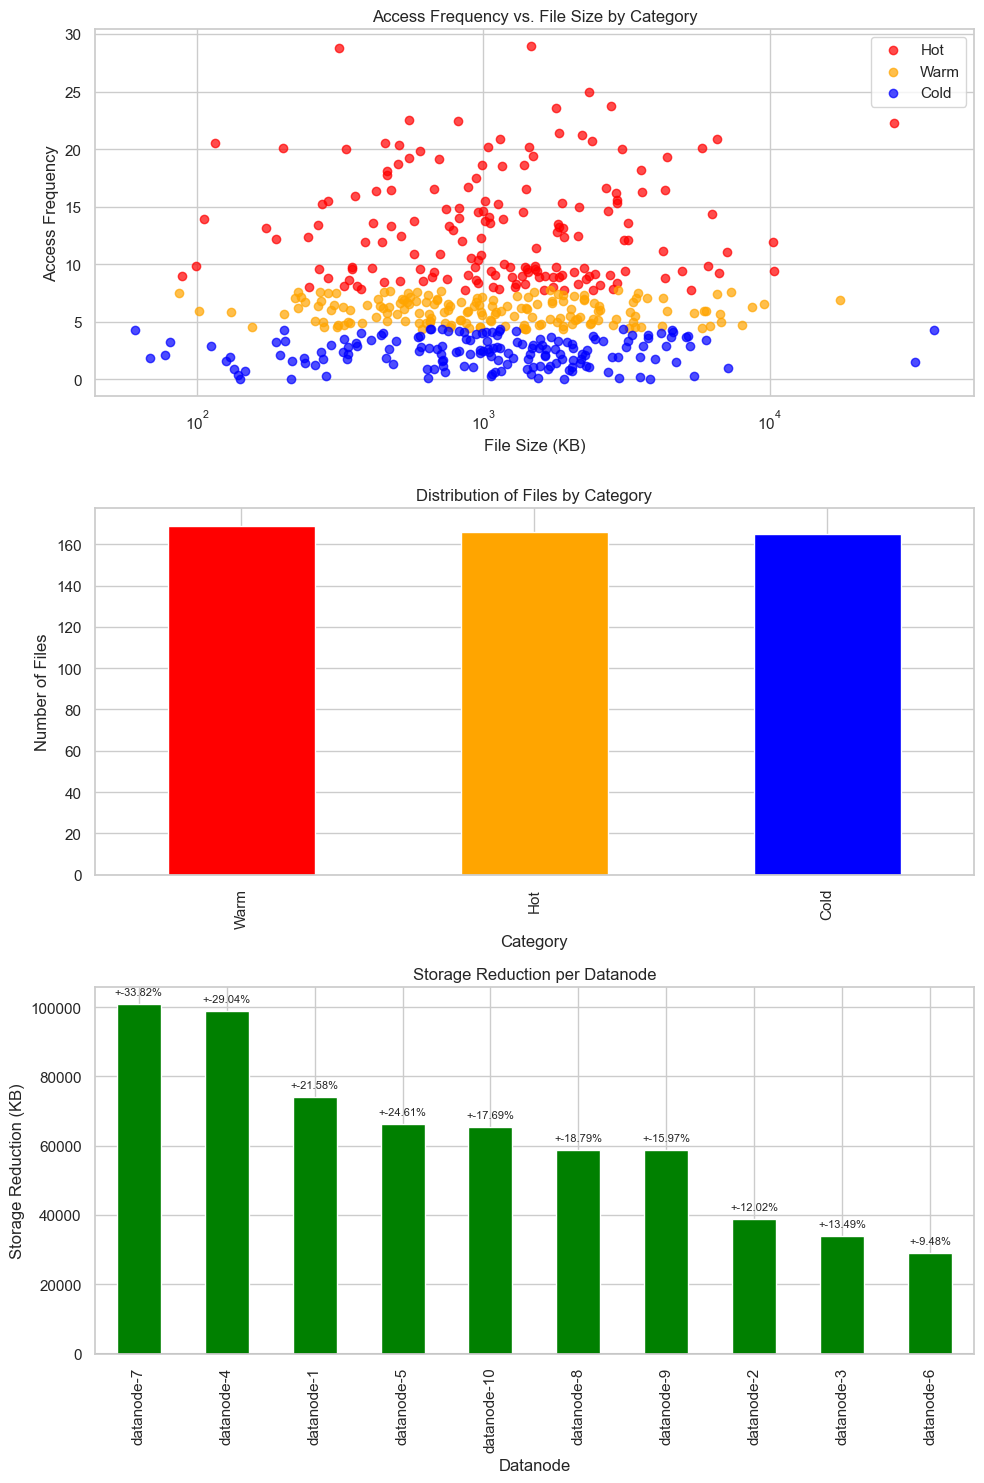


=== Datanode Storage Comparison Table ===
   Datanode  Before (KB)  After (KB)  Diff (KB) Change (%)  Reduction (KB)
datanode-10    369656.26   304276.87  -65379.39    -17.69%        65379.39
 datanode-9    368002.32   309224.10  -58778.22    -15.97%        58778.22
 datanode-1    343356.57   269261.44  -74095.13    -21.58%        74095.13
 datanode-4    340403.44   241533.27  -98870.17    -29.04%        98870.17
 datanode-2    322654.40   283878.81  -38775.59    -12.02%        38775.59
 datanode-8    313395.97   254508.11  -58887.86    -18.79%        58887.86
 datanode-6    306518.77   277467.86  -29050.92     -9.48%        29050.92
 datanode-7    297977.49   197208.09 -100769.40    -33.82%       100769.40
 datanode-5    268725.90   202602.70  -66123.20    -24.61%        66123.20
 datanode-3    251380.34   217478.77  -33901.57    -13.49%        33901.57

=== Total Storage Impact ===
Total Storage Before: 3182071.47 KB
Total Storage After: 2557440.02 KB
Net Change: -624631.45 KB (-19.

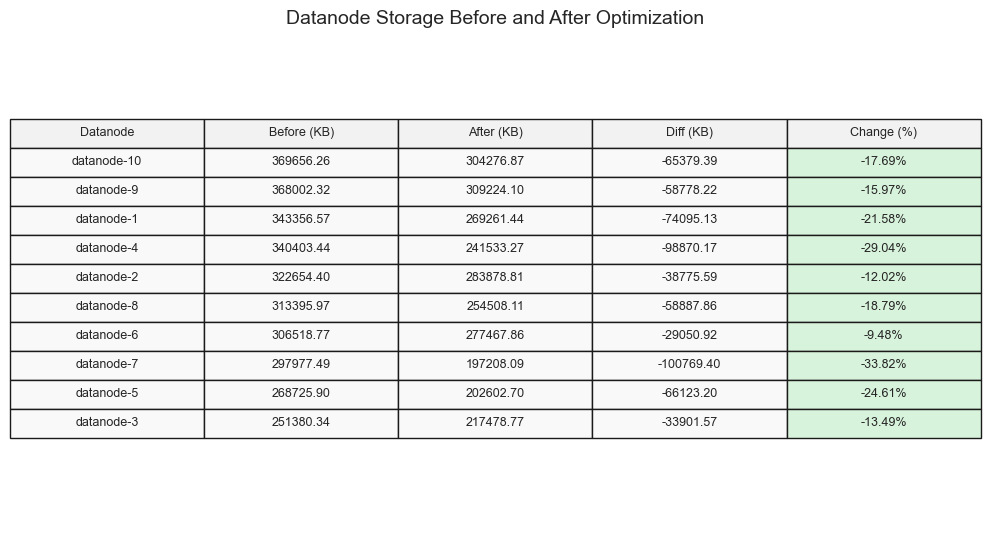

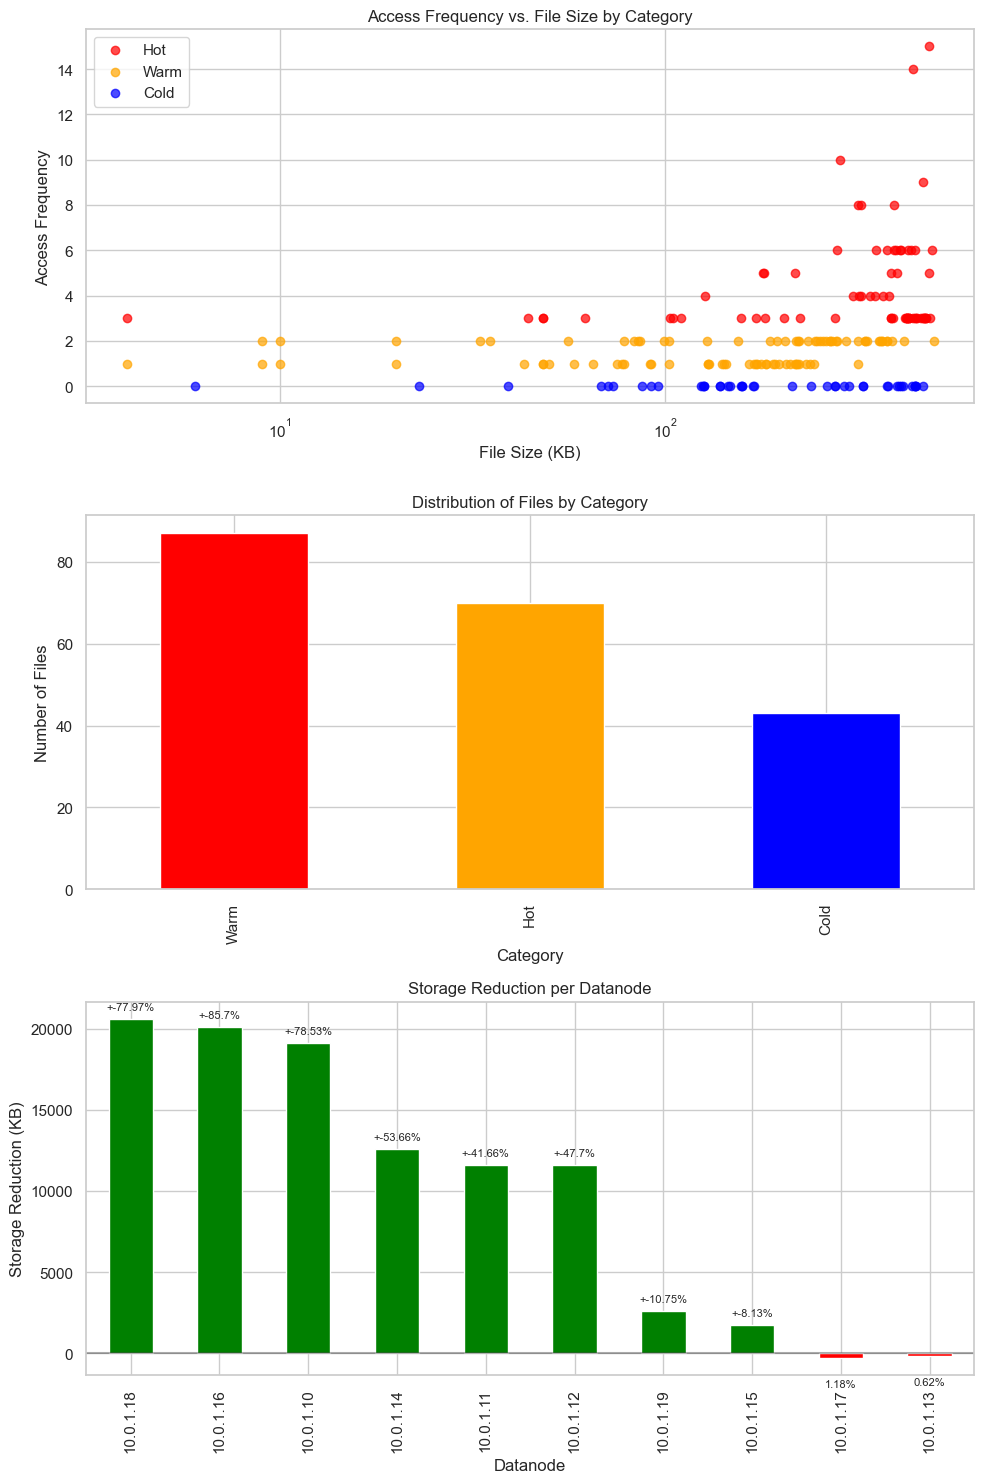


=== Datanode Storage Comparison Table ===
 Datanode  Before (KB)  After (KB)  Diff (KB) Change (%)  Reduction (KB)
10.0.1.11        27859       16252     -11607    -41.66%           11607
10.0.1.17        26965       27282        317      1.18%            -317
10.0.1.18        26443        5825     -20618    -77.97%           20618
10.0.1.13        26415       26579        164      0.62%            -164
10.0.1.10        24303        5217     -19086    -78.53%           19086
10.0.1.12        24290       12704     -11586     -47.7%           11586
10.0.1.19        24028       21444      -2584    -10.75%            2584
10.0.1.16        23470        3357     -20113     -85.7%           20113
10.0.1.14        23413       10849     -12564    -53.66%           12564
10.0.1.15        21502       19753      -1749     -8.13%            1749

=== Total Storage Impact ===
Total Storage Before: 248688.00 KB
Total Storage After: 149262.00 KB
Net Change: -99426.00 KB (-39.98%)

=== Replication Ano

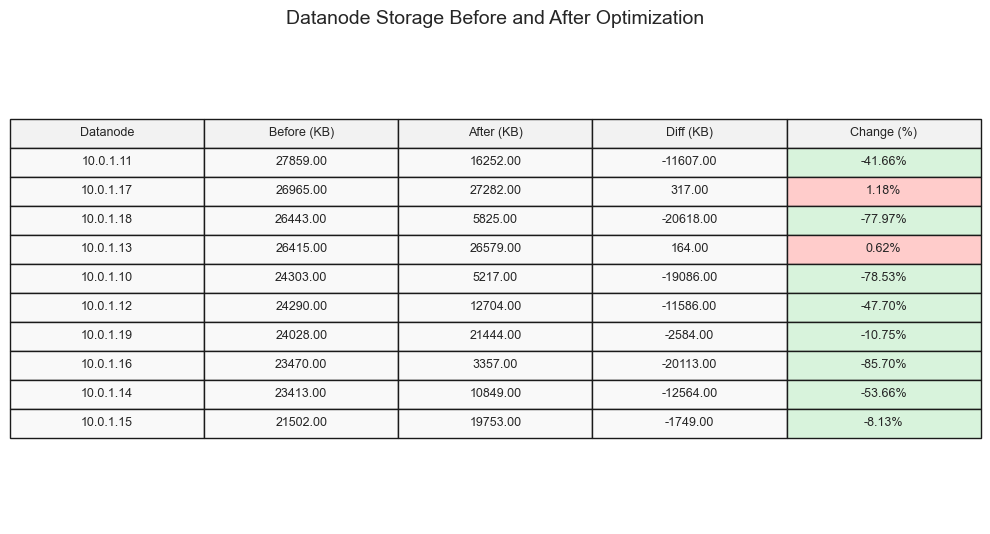

In [4]:
def data_for_clustering(data):
    features = []
    for item in data:
        block_count = len(item.get("blocks_on_datanodes", {}))
        datanode_count = len(item.get("datanodes_containing_file", []))
        file_path = item.get("file_path", "")
        file_type = file_path.split(".")[-1] if "." in file_path else "unknown"
        file_type_numeric = hash(file_type) % 10  
        file_size_mb = max(item.get("file_size", 1) / 1024, 0.001)  
        access_density = item.get("access_frequency", 0) / file_size_mb      
        features.append({
            "file_path": item.get("file_path", ""),
            "file_size": item.get("file_size", 0),
            "access_frequency": item.get("access_frequency", 0),
            "client_count": item.get("client_count", 0),
            "block_count": block_count,
            "datanode_count": datanode_count,
            "file_type_numeric": file_type_numeric,
            "access_density": access_density,
            "current_replication_factor": item.get("replication_factor", 3),
            "datanodes": item.get("datanodes_containing_file", []),
            "blocks_on_datanodes": item.get("blocks_on_datanodes", {}) })
    
    return pd.DataFrame(features)

def analyze_access_distribution(data_df):
    
    if len(data_df) < 5:
        print("Warning: Not enough data for reliable distribution analysis. Using default thresholds.")
        return {'hot': 8, 'warm': 3}
    
    quantiles = [0.33, 0.67]  
    thresholds = {}
    
    for i, q in enumerate(quantiles):
        thresholds[i] = data_df['access_frequency'].quantile(q)
    
    warm_threshold = thresholds[0]
    hot_threshold = thresholds[1]
    
    if hot_threshold - warm_threshold < 2:
        adjustment = (2 - (hot_threshold - warm_threshold)) / 2
        warm_threshold -= adjustment
        hot_threshold += adjustment
    
    warm_threshold = max(1, warm_threshold)
    hot_threshold = max(warm_threshold + 1, hot_threshold) 
    print(f"Access frequency distribution analysis:")
    print(f"  Min: {data_df['access_frequency'].min()}")
    print(f"  25%: {data_df['access_frequency'].quantile(0.25)}")
    print(f"  Median: {data_df['access_frequency'].median()}")
    print(f"  75%: {data_df['access_frequency'].quantile(0.75)}")
    print(f"  Max: {data_df['access_frequency'].max()}")
    print(f"Derived thresholds - Hot: >{hot_threshold}, Warm: >{warm_threshold}")
    
    return {'hot': hot_threshold, 'warm': warm_threshold}

def hierarchical_clustering(data_df, n_clusters=3):
   
    thresholds = analyze_access_distribution(data_df)
    hot_threshold = thresholds['hot']
    warm_threshold = thresholds['warm']
    features = ['file_size', 'access_frequency', 'client_count', 'access_density']
    X = data_df[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    hierarchical_model = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_clusters = hierarchical_model.fit_predict(X_scaled)
    data_df['hierarchical_cluster'] = hierarchical_clusters
    result_df = data_df.copy()
    conditions = [
        (result_df['access_frequency'] >= hot_threshold),
        (result_df['access_frequency'] >= warm_threshold),
        (result_df['access_frequency'] < warm_threshold)]
    choices = ['Hot', 'Warm', 'Cold']
    result_df['category'] = np.select(conditions, choices, default='Unknown')
    category_counts = result_df['category'].value_counts()
    print(f"Category distribution after threshold-based assignment:")
    for category, count in category_counts.items():
        print(f"  {category}: {count}")
    return result_df

def kmeans_subclustering(data_df, max_subclusters=5):
    result_df = data_df.copy()
    features = ['file_size', 'access_frequency', 'client_count', 'access_density']
    
    for category in data_df['category'].unique():
        category_mask = data_df['category'] == category
        category_data_count = sum(category_mask)
    
        if category_data_count <= 5:
            result_df.loc[category_mask, 'kmeans_subcluster'] = 0
            print(f"Category {category} has only {category_data_count} samples, skipping K-means subclustering")
            continue
        
        X_category = data_df.loc[category_mask, features].values
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_category)
        max_possible_clusters = min(max_subclusters, category_data_count // 2)
        if max_possible_clusters < 2:
            result_df.loc[category_mask, 'kmeans_subcluster'] = 0
            print(f"Category {category} has {category_data_count} samples, using single subcluster")
            continue
        possible_clusters = range(2, max_possible_clusters + 1)
        silhouette_scores = []
        for n_clusters in possible_clusters:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, init='k-means++')
            cluster_labels = kmeans.fit_predict(X_scaled)     
            try:
                score = silhouette_score(X_scaled, cluster_labels)
                silhouette_scores.append(score)
                print(f"Category {category}, clusters {n_clusters}, silhouette score: {score:.4f}")
            except Exception as e:
                print(f"Error calculating silhouette score for {n_clusters} clusters: {e}")
                silhouette_scores.append(-1)        
        if silhouette_scores and max(silhouette_scores) > 0:
            best_score_idx = np.argmax(silhouette_scores)
            best_n_clusters = list(possible_clusters)[best_score_idx]
            print(f"Best number of clusters for {category}: {best_n_clusters} (score: {silhouette_scores[best_score_idx]:.4f})")
        else:
            best_n_clusters = 2
            print(f"Using default {best_n_clusters} clusters for {category} due to poor silhouette scores")        
        kmeans_model = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10, init='k-means++')
        subclusters = kmeans_model.fit_predict(X_scaled)
        result_df.loc[category_mask, 'kmeans_subcluster'] = subclusters    
    result_df['final_cluster'] = result_df['category'] + '_' + result_df['kmeans_subcluster'].astype(str)
    return result_df

def generate_training_data(clustered_data, recommendations):
    thresholds = analyze_access_distribution(clustered_data)
    hot_threshold = thresholds['hot']
    warm_threshold = thresholds['warm']    
    training_data = []    
    for _, row in clustered_data.iterrows():
        features = {
            'file_path': row['file_path'],
            'file_size': row['file_size'],
            'access_frequency': row['access_frequency'],
            'client_count': row['client_count'],
            'access_density': row['access_density'],
            'block_count': row.get('block_count', 1),
            'datanode_count': row.get('datanode_count', 1),
            'category': row['category'],
            'current_replication_factor': row['current_replication_factor'],
            'recommended_replication_factor': row['current_replication_factor'] }
        training_data.append(features)    
    for rec in recommendations.get('recommendations', []):
        file_size = rec.get('file_size_mb', 1) * 1024  
        block_count = 1 
        datanode_count = len(rec.get('current_datanodes', []))        
        access_freq = rec.get('access_frequency', 0)
        if access_freq >= hot_threshold:
            category = 'Hot'
        elif access_freq >= warm_threshold:
            category = 'Warm'
        else:
            category = 'Cold'
        
        features = {
            'file_path': rec['file_path'],
            'file_size': file_size,
            'access_frequency': rec['access_frequency'],
            'client_count': rec['client_count'],
            'access_density': rec['access_density'],
            'block_count': block_count,
            'datanode_count': datanode_count,
            'category': category,
            'current_replication_factor': rec['current_replication_factor'],
            'recommended_replication_factor': rec['recommended_replication_factor'] }
        training_data.append(features)
    return pd.DataFrame(training_data)
def train_replication_model(training_data):
    features = ['file_size', 'access_frequency', 'client_count', 'access_density', 
                'block_count', 'datanode_count']
    
    training_data_encoded = pd.get_dummies(training_data, columns=['category'])
    X = training_data_encoded[features + [col for col in training_data_encoded.columns if col.startswith('category_')]]
    y = training_data_encoded['recommended_replication_factor']
    print(f"Training model with {len(X)} samples")
    print(f"Feature columns: {X.columns.tolist()}")
    print(f"Target replication factor distribution: {y.value_counts().to_dict()}")
    if len(X) < 10:
        print("Warning: Small training dataset. Using simplified model.")
        model = xgb.XGBRegressor(
            objective='reg:squarederror', 
            n_estimators=50,
            max_depth=2,
            learning_rate=0.1)
    else:
        model = xgb.XGBRegressor(
            objective='reg:squarederror', 
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            min_child_weight=2,
            subsample=0.8,
            colsample_bytree=0.8 )   
    if len(X) >= 20:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        print(f"Model MSE on test set: {mse:.4f}")
    else:
        print("Not enough data for train/test split. Training on all data.")
        model.fit(X, y)
    feature_importance = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importance}).sort_values('Importance', ascending=False)
    print("\nFeature importance:")
    for i, row in importance_df.head(5).iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")
    return model, X.columns

def validate_replication_recommendations(data_with_predictions):
    result_df = data_with_predictions.copy()    
    current_reps = result_df['current_replication_factor']
    predicted_reps = result_df['predicted_replication_factor']
    print("\nReplication factor statistics:")
    print(f"  Current: min={current_reps.min()}, max={current_reps.max()}, mean={current_reps.mean():.2f}")
    print(f"  Predicted: min={predicted_reps.min()}, max={predicted_reps.max()}, mean={predicted_reps.mean():.2f}")    
    changes = predicted_reps - current_reps
    increase = (changes > 0).sum()
    decrease = (changes < 0).sum()
    no_change = (changes == 0).sum()
    print(f"Recommendations: {increase} increases, {decrease} decreases, {no_change} no change")    
    max_change = 2  
    extreme_changes = (abs(changes) > max_change)
    
    if extreme_changes.any():
        print(f"Warning: Limiting {extreme_changes.sum()} extreme replication factor changes (>{max_change})")        
        capped_changes = changes.copy()
        capped_changes[changes > max_change] = max_change
        capped_changes[changes < -max_change] = -max_change        
        result_df['predicted_replication_factor'] = current_reps + capped_changes    
    if (result_df['predicted_replication_factor'] < 1).any():
        print(f"Warning: Adjusting {(result_df['predicted_replication_factor'] < 1).sum()} recommendations below minimum replication factor of 1")
        result_df['predicted_replication_factor'] = result_df['predicted_replication_factor'].clip(lower=1)    
    hot_mask = result_df['category'] == 'Hot'
    if (result_df.loc[hot_mask, 'predicted_replication_factor'] < 2).any():
        print(f"Warning: Ensuring Hot category files have minimum replication factor of 2")
        result_df.loc[hot_mask, 'predicted_replication_factor'] = result_df.loc[hot_mask, 'predicted_replication_factor'].clip(lower=2)
    return result_df

def calculate_datanode_storage(data_with_predictions):
    
    datanode_storage = {}
    for _, file in data_with_predictions.iterrows():
        file_size = file['file_size']
 
        datanodes = file.get('datanodes', [])
       
        if datanodes:
            for datanode in datanodes:
                if datanode not in datanode_storage:
                    datanode_storage[datanode] = {'before': 0, 'after': 0}
                datanode_storage[datanode]['before'] += file_size
        else:
           continue

    for _, file in data_with_predictions.iterrows():
        file_size = file['file_size']
        datanodes = file.get('datanodes', [])
        current_rep = int(file['current_replication_factor'])
        predicted_rep = int(file['predicted_replication_factor'])
        if datanodes:
            if predicted_rep <= len(datanodes):
                selected_datanodes = datanodes[:predicted_rep]

            else:
                selected_datanodes = datanodes
                additional_needed = predicted_rep - len(datanodes)                
                additional_needed = predicted_rep - len(datanodes)
                for i in range(additional_needed):
                    selected_datanodes.append(datanodes[i % len(datanodes)])

            for datanode in selected_datanodes:
                datanode_storage[datanode]['after'] += file_size
    
    storage_df = pd.DataFrame.from_dict(datanode_storage, orient='index')
    storage_df['difference'] = storage_df['after'] - storage_df['before']
    storage_df['percent_change'] = (storage_df['difference'] / storage_df['before'] * 100).round(2)
    storage_df = storage_df.sort_values('before', ascending=False)
    return storage_df

def main(processing_data, recommendations_data):
    print("Starting HDFS optimization analysis...")
    print("\nprocessing data...")
    data_df = data_for_clustering(processing_data)
    if len(data_df) < 3:
        print("\nWARNING: Very small dataset detected. Analysis results may not be reliable.")
        print(f"Only {len(data_df)} files found in the processing data.")    
    print("\nApplying hierarchical clustering with data-driven thresholds...")
    hierarchical_results = hierarchical_clustering(data_df, n_clusters=min(3, len(data_df)))    
    print("\nApplying K-means subclustering...")
    final_clusters = kmeans_subclustering(hierarchical_results, max_subclusters=min(4, len(data_df) // 2))    
    print("\nGenerating training data...")
    training_data = generate_training_data(final_clusters, recommendations_data)
    print("\nTraining ML model for replication factor prediction...")
    model, feature_columns = train_replication_model(training_data)
    print("\nPredicting optimal replication factors...")
    predictions = predict_replication_factors(model, feature_columns, final_clusters)
    print("\nValidating replication recommendations...")
    validated_predictions = validate_replication_recommendations(predictions)
    print("\nDetecting replication factor anomalies...")
    anomalies = detect_replication_anomalies(validated_predictions)
    print("\nCalculating datanode storage impact...")
    datanode_storage = calculate_datanode_storage(validated_predictions)
    print("\nGenerating visualizations...")
    visualizations = generate_visualizations(validated_predictions, anomalies, datanode_storage)
    print("\n=== Replication Anomalies ===")
    print(f"Total anomalies detected: {len(anomalies)}")
    if not anomalies.empty:
        over_replicated = len(anomalies[anomalies['current_replication_factor'] > anomalies['recommended_replication_factor']])
        under_replicated = len(anomalies[anomalies['current_replication_factor'] < anomalies['recommended_replication_factor']])
        print(f"Over-replicated files: {over_replicated}")
        print(f"Under-replicated files: {under_replicated}")
        if len(anomalies) > 0:
            print("\n=== Sample Recommendations ===")
            for i, (_, row) in enumerate(anomalies.iterrows()):
                print(f"{i+1}. File: {row['file_path']}")
                print(f"   Current replication: {row['current_replication_factor']} → Recommended: {row['recommended_replication_factor']}")
                print(f"   Reason: {row['reason']}")
                print(f"   Storage impact: {row['storage_impact']}")
                if i >= 2:  # Show at most 3 examples
                    break
    else:
        print("No replication anomalies detected.")    
    print("\n=== Datanode Storage Impact ===")
    print(datanode_storage.to_string())
    print("\nAnalysis complete!")
    return validated_predictions, anomalies, visualizations, datanode_storage

def predict_replication_factors(model, feature_columns, clustered_data):
    clustered_data_encoded = pd.get_dummies(clustered_data, columns=['category'])    
    for col in feature_columns:
        if col not in clustered_data_encoded.columns:
            clustered_data_encoded[col] = 0
    X_pred = clustered_data_encoded[feature_columns]
    predictions = model.predict(X_pred)
    clustered_data['predicted_replication_factor'] = np.round(predictions).astype(int)    
    clustered_data['predicted_replication_factor'] = clustered_data['predicted_replication_factor'].clip(lower=1)
    return clustered_data

def detect_replication_anomalies(data_with_predictions):
    anomalies = []
    for _, row in data_with_predictions.iterrows():
        current_rep = row['current_replication_factor']
        predicted_rep = row['predicted_replication_factor']
        if current_rep != predicted_rep:
            file_size = row['file_size']
            storage_diff = file_size * abs(current_rep - predicted_rep)
            storage_impact = f"{storage_diff} KB {'saved' if current_rep > predicted_rep else 'added'}"            
            if current_rep > predicted_rep:
                reason = f"{row['category']} data with access frequency {row['access_frequency']} and client count {row['client_count']} " \
                         f"is over-replicated. Reducing from {current_rep} to {predicted_rep} will save storage."
            else:
                reason = f"{row['category']} data with access frequency {row['access_frequency']} and client count {row['client_count']} " \
                         f"is under-replicated. Increasing from {current_rep} to {predicted_rep} will improve availability and performance."
            anomalies.append({
                'file_path': row['file_path'],
                'current_replication_factor': current_rep,
                'recommended_replication_factor': predicted_rep,
                'category': row['category'],
                'access_frequency': row['access_frequency'],
                'client_count': row['client_count'],
                'file_size': row['file_size'],
                'storage_impact': storage_impact,
                'reason': reason })
    return pd.DataFrame(anomalies) if anomalies else pd.DataFrame(columns=[
        'file_path', 'current_replication_factor', 'recommended_replication_factor',
        'category', 'access_frequency', 'client_count', 'file_size',
        'storage_impact', 'reason'])

def generate_visualizations(clustered_data, anomalies, datanode_storage):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))    
    ax = axes[0]
    category_colors = {'Hot': 'red', 'Warm': 'orange', 'Cold': 'blue'}
    for category, color in category_colors.items():
        subset = clustered_data[clustered_data['category'] == category]
        if not subset.empty:
            ax.scatter(subset['file_size'], subset['access_frequency'], 
                    c=color, label=category, alpha=0.7)
    ax.set_xlabel('File Size (KB)')
    ax.set_ylabel('Access Frequency')
    ax.set_title('Access Frequency vs. File Size by Category')
    ax.legend()
    ax.set_xscale('log') 
    ax = axes[1]
    category_counts = clustered_data['category'].value_counts()
    if not category_counts.empty:
        category_counts.plot(kind='bar', ax=ax, color=['red', 'orange', 'blue'])
    ax.set_xlabel('Category')
    ax.set_ylabel('Number of Files')
    ax.set_title('Distribution of Files by Category')    
    ax = axes[2]
    if not datanode_storage.empty:
        datanode_storage['difference_abs'] = abs(datanode_storage['difference'])
        datanode_storage['reduction'] = datanode_storage['before'] - datanode_storage['after'] 
        sorted_storage = datanode_storage.sort_values('difference_abs', ascending=False)        
        colors = ['green' if val > 0 else 'red' for val in sorted_storage['reduction']]        
        sorted_storage['reduction'].plot(kind='bar', ax=ax, color=colors)
        ax.set_xlabel('Datanode')
        ax.set_ylabel('Storage Reduction (KB)')
        ax.set_title('Storage Reduction per Datanode')
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)        
        for i, val in enumerate(sorted_storage['percent_change']):
            sign = '+' if val < 0 else '' 
            ax.annotate(f'{sign}{val}%', 
                        xy=(i, sorted_storage['reduction'].iloc[i]),
                        xytext=(0, 5 if sorted_storage['reduction'].iloc[i] >= 0 else -15),
                        textcoords='offset points',
                        ha='center',
                        va='bottom' if sorted_storage['reduction'].iloc[i] >= 0 else 'top',
                        fontsize=8)
    fig.tight_layout()
    plt.show()
    fig_table, ax_table = plt.subplots(figsize=(10, len(datanode_storage) * 0.4 + 1.5))
    ax_table.axis('off')    
    if not datanode_storage.empty:
        table_data = datanode_storage.copy()
        table_data['reduction'] = table_data['before'] - table_data['after']        
        display_data = []
        for idx, row in table_data.iterrows():
            display_data.append([
                idx,f"{row['before']:.2f}", f"{row['after']:.2f}", f"{row['difference']:.2f}", f"{row['percent_change']:.2f}%" ])        
        cell_colors = []
        for row in table_data.iterrows():
            reduction = row[1]['before'] - row[1]['after']
            if reduction > 0:
                cell_colors.append(['#f9f9f9', '#f9f9f9', '#f9f9f9', '#f9f9f9', '#d8f3dc'])  
            else:
                cell_colors.append(['#f9f9f9', '#f9f9f9', '#f9f9f9', '#f9f9f9', '#ffcccb'])  
        table = ax_table.table(
            cellText=display_data,
            colLabels=['Datanode', 'Before (KB)', 'After (KB)', 'Diff (KB)', 'Change (%)'],
            loc='center',
            cellLoc='center',
            colColours=['#f2f2f2'] * 5,
            cellColours=cell_colors) 
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Datanode Storage Before and After Optimization', fontsize=14)
    else:
        plt.text(0.5, 0.5, "No datanode storage data available", ha='center', va='center')
    
    plt.tight_layout()    
    print("\n=== Datanode Storage Comparison Table ===")
    formatted_table = pd.DataFrame({
        'Datanode': datanode_storage.index.tolist(),
        'Before (KB)': datanode_storage['before'].round(2),
        'After (KB)': datanode_storage['after'].round(2),
        'Diff (KB)': datanode_storage['difference'].round(2),
        'Change (%)': datanode_storage['percent_change'].round(2).astype(str) + '%',
        'Reduction (KB)': (datanode_storage['before'] - datanode_storage['after']).round(2) })    
    print(formatted_table.to_string(index=False))    
    total_before = datanode_storage['before'].sum()
    total_after = datanode_storage['after'].sum()
    total_diff = total_after - total_before
    total_percent = (total_diff / total_before * 100) if total_before > 0 else 0
    
    print("\n=== Total Storage Impact ===")
    print(f"Total Storage Before: {total_before:.2f} KB")
    print(f"Total Storage After: {total_after:.2f} KB")
    print(f"Net Change: {total_diff:.2f} KB ({total_percent:.2f}%)")    
    return [fig, fig_table]
       
if __name__ == "__main__":

    processing_data_path1 = 'working/hdfs_parsed_data.json'
    recommendations_data_path1 = 'working/replication_optimization.json'
    processing_data_path = 'hdfs_logs/hdfs_parsed_data.json'
    recommendations_data_path = 'hdfs_logs/replication_optimization.json'    

    with open(processing_data_path1, 'r') as processing_file:
            processing_data1 = json.load(processing_file)
            print(f"Loaded processing data from: {processing_data_path1}")    
    with open(recommendations_data_path1, 'r') as recommendations_file:
            recommendations_data1 = json.load(recommendations_file)
            print(f"Loaded recommendations data from: {recommendations_data_path1}")
    main(processing_data1, recommendations_data1)
    with open(processing_data_path, 'r') as processing_file:
            processing_data = json.load(processing_file)
            print(f"Loaded processing data from: {processing_data_path}")    
    with open(recommendations_data_path, 'r') as recommendations_file:
            recommendations_data = json.load(recommendations_file)
            print(f"Loaded recommendations data from: {recommendations_data_path}")
    main(processing_data, recommendations_data)
    